In [8]:
#dependencies 
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit, LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from lazypredict.Supervised import LazyRegressor

In [9]:
plt.rcParams.update({'font.size': 30})
plt.style.use('fivethirtyeight')
sns.set(rc={'figure.figsize':(12,10)})
sns.set_context("talk", font_scale=1.2, rc={"lines.linewidth": 2.5})
sns.set_style("ticks")
sns.despine()
%matplotlib inline

In [39]:
audi =pd.read_csv('/home/hrushikesh/work_place/eda/audi.xls')
bmw = pd.read_csv('/home/hrushikesh/work_place/eda/bmw.xls')
ford = pd.read_csv('/home/hrushikesh/work_place/eda/ford.xls')
toyota = pd.read_csv('/home/hrushikesh/work_place/eda/toyota.xls')
datasets = [audi,bmw,ford,toyota]

In [10]:
pwd

'/home/hrushikesh/work_place/eda'

In [16]:
audi.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.40,1.40
1,A6,2016,16500,Automatic,36203,Diesel,20,64.20,2.00
2,A1,2016,11000,Manual,29946,Petrol,30,55.40,1.40
3,A4,2017,16800,Automatic,25952,Diesel,145,67.30,2.00
4,A3,2019,17300,Manual,1998,Petrol,145,49.60,1.00


In [23]:
#Getting all the unique values in each feature
features = audi.columns
for feature in features:
    print(f"{feature} ---> {audi[feature].nunique()}")

#clever way of describing df
audi.describe().T.sort_values(ascending = 0,by = "mean").style.background_gradient(cmap = "BuGn")\
.bar(subset = ["std"], color ="red").bar(subset = ["mean"], color ="blue")

model ---> 26
year ---> 21
price ---> 3260
transmission ---> 3
mileage ---> 7725
fuelType ---> 3
tax ---> 37
mpg ---> 104
engineSize ---> 19


,count,mean,std,min,25%,50%,75%,max
mileage,10668.00,24827.24,23505.26,1.00,5968.75,19000.00,36464.50,323000.00
price,10668.00,22896.69,11714.84,1490.00,15130.75,20200.00,27990.00,145000.00
year,10668.00,2017.10,2.17,1997.00,2016.00,2017.00,2019.00,2020.00
tax,10668.00,126.01,67.17,0.00,125.00,145.00,145.00,580.00
mpg,10668.00,50.77,12.95,18.90,40.90,49.60,58.90,188.30
engineSize,10668.00,1.93,0.60,0.00,1.50,2.00,2.00,6.30


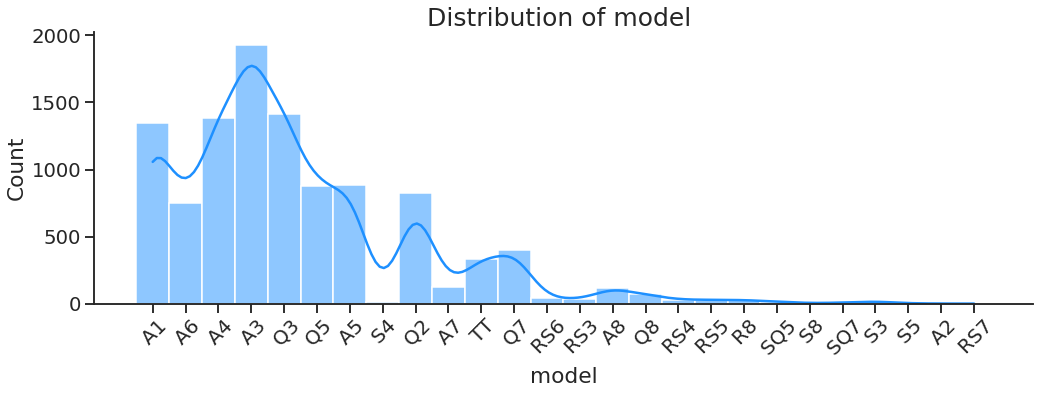

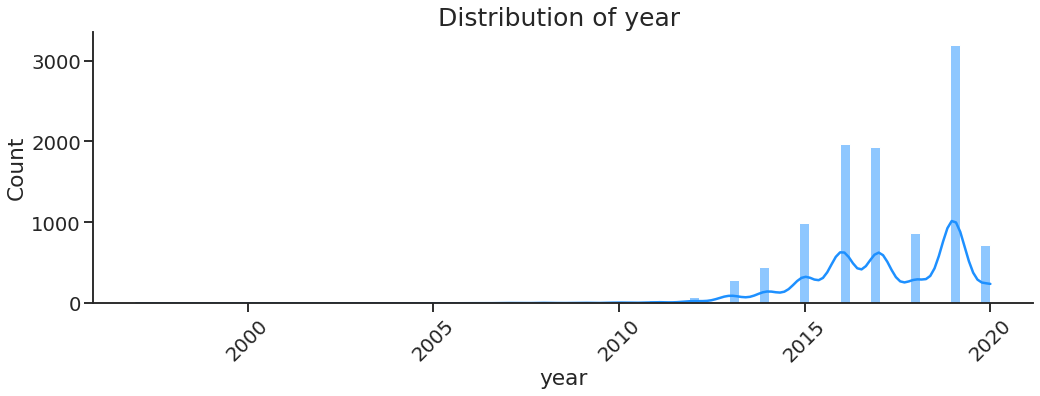

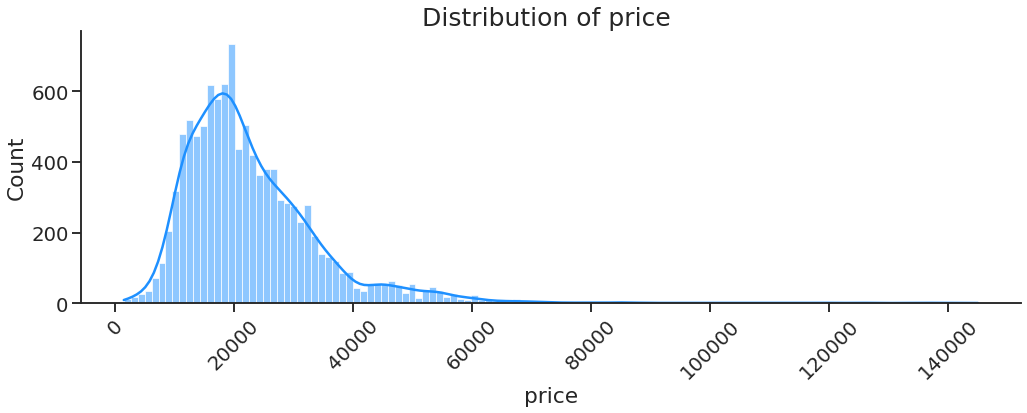

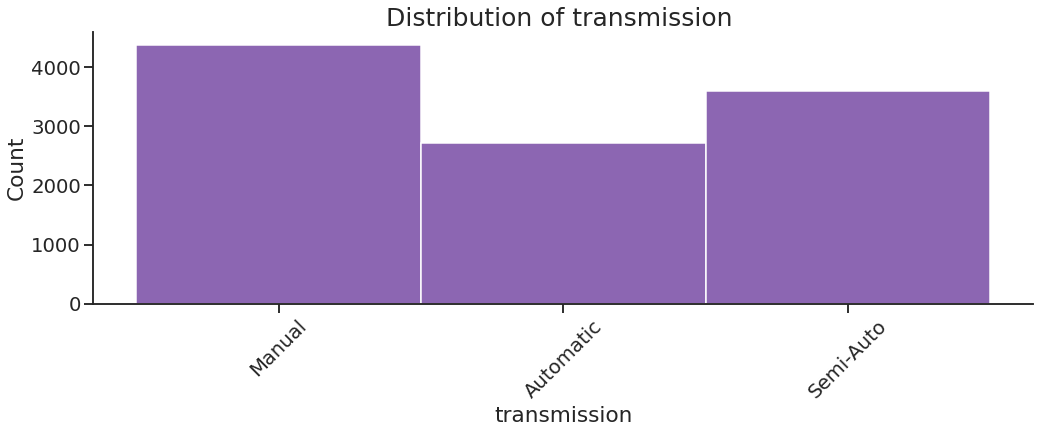

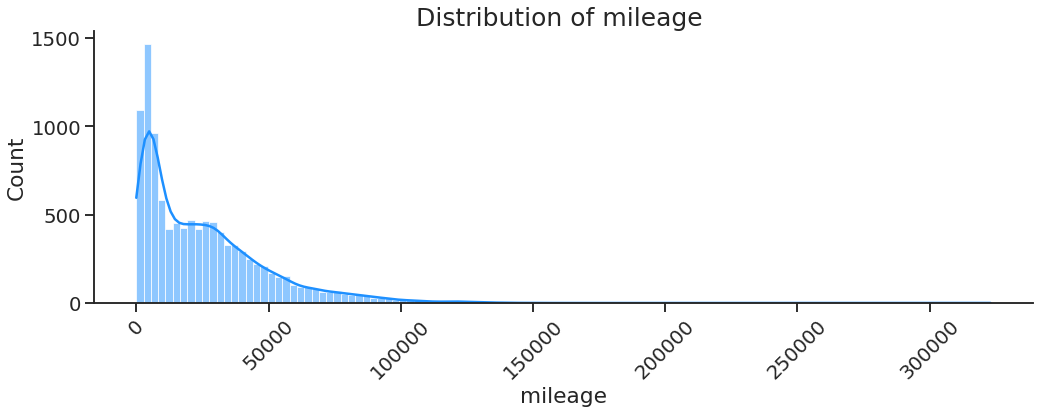

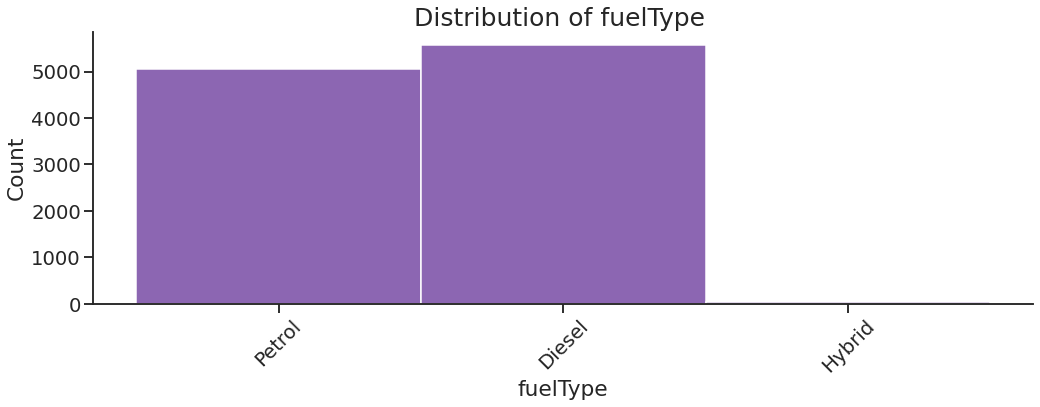

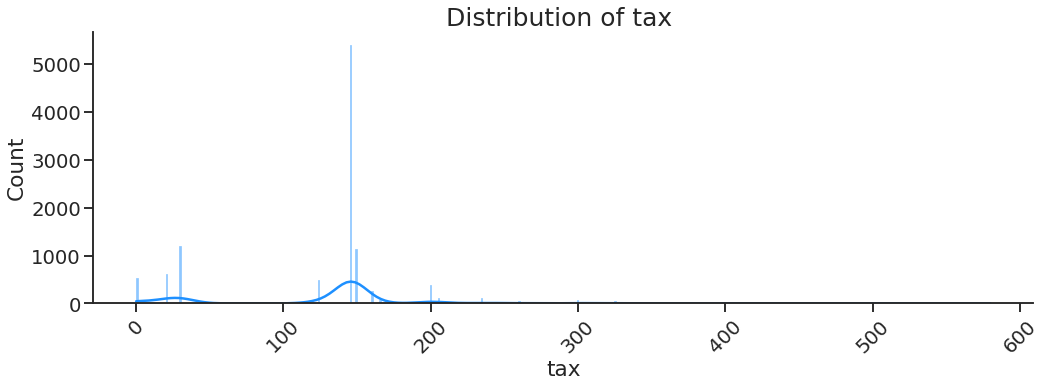

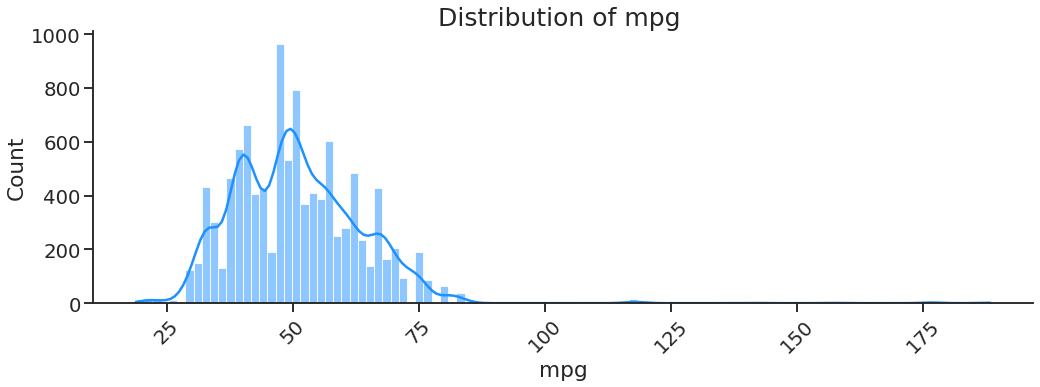

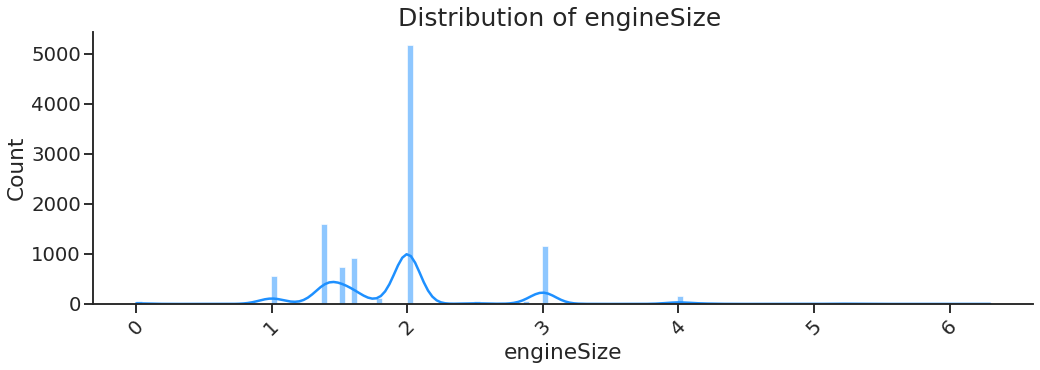

In [24]:
features = audi.columns
for feature in features:
    if audi[feature].nunique() > 4:
        plt.figure(figsize=(15,5))
        sns.histplot(data = features, x = audi[feature], color = 'dodgerblue', kde = True)
        plt.title(f"Distribution of {feature} ",fontsize = 25)
        sns.despine()
        plt.xticks(rotation=45)
        plt.show()
    else:
        plt.figure(figsize=(15,5))
        sns.histplot(data = features, x = audi[feature], color = 'rebeccapurple', kde = False)
        plt.title(f"Distribution of {feature} ",fontsize = 25)
        sns.despine()
        plt.xticks(rotation=45)
        plt.show()

In [26]:
# Many of these features are right skewed and I want to see how they would look 
# if we were to apply a log transformation on them. Lets do that for those 
# features above that look like they'd benefit from it

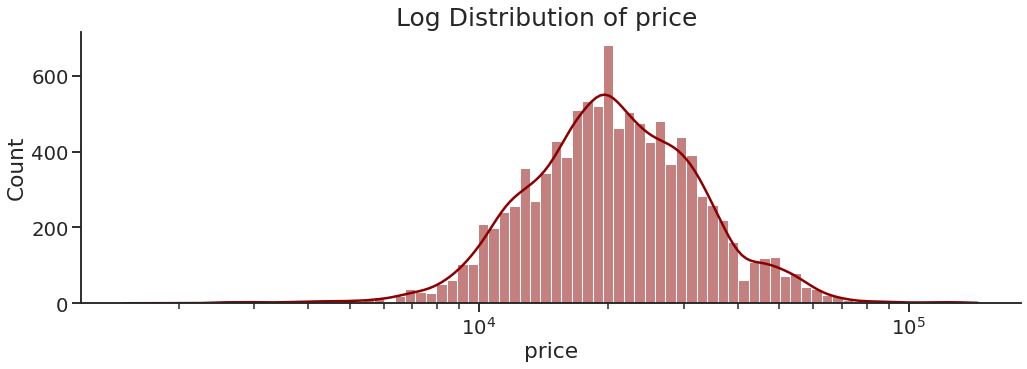

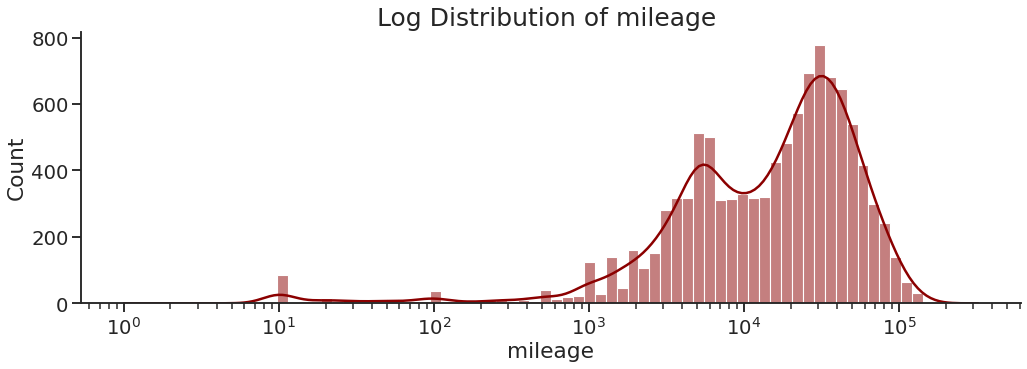

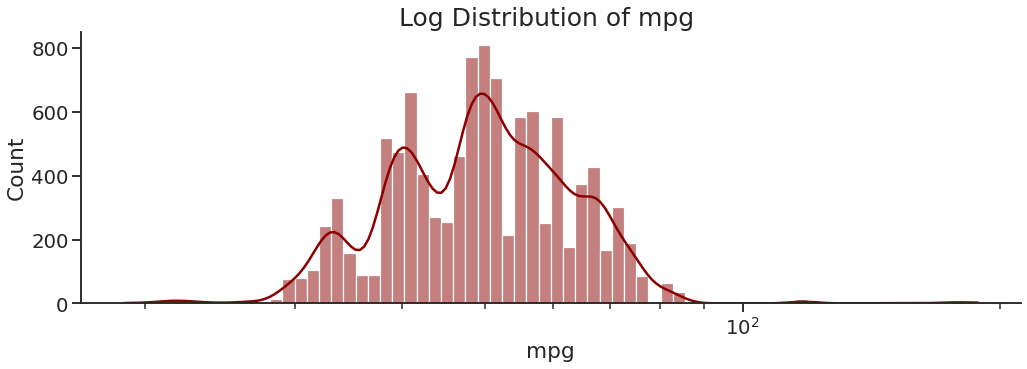

In [27]:
log_df=audi[['price','mileage','mpg']]
log_features = log_df.columns
for feature in log_features:
    if audi[feature].nunique() > 4:
        plt.figure(figsize=(15,5))
        sns.histplot(data = features, x = audi[feature], color = 'darkred', kde = True, log_scale=True)
        plt.title(f"Log Distribution of {feature} ",fontsize = 25)
        sns.despine()
        plt.show()

It looks like we overcorrected mileage and price somwhat. 
The issue with mileage and price is just a few extreme outliers I think, not the entire distribution


In [38]:
audi.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A3,2017,12500,Manual,15735,Petrol,150,55.40,1.40
1,A3,2016,16500,Automatic,36203,Diesel,20,64.20,2.00
2,A3,2016,11000,Manual,29946,Petrol,30,55.40,1.40
3,A3,2017,16800,Automatic,25952,Diesel,145,67.30,2.00
4,A3,2019,17300,Manual,1998,Petrol,145,49.60,1.00


In [43]:
audi.loc[(audi.model == "A3")]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize


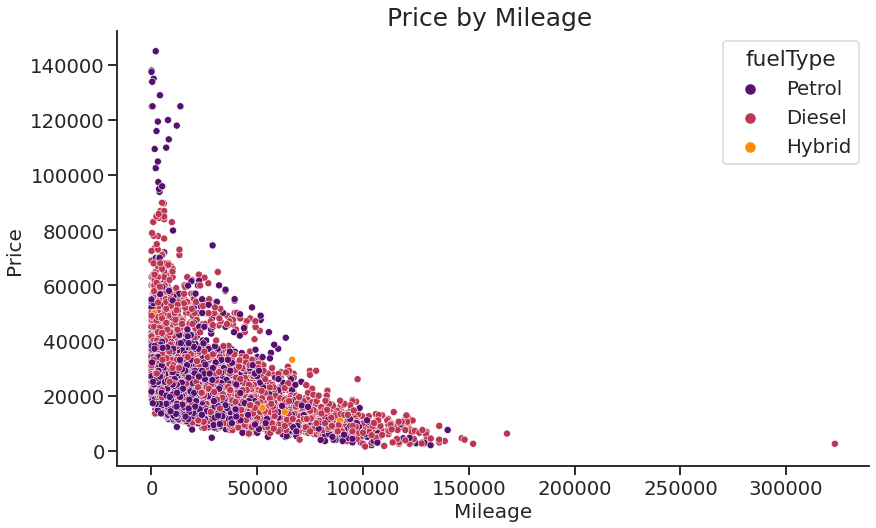

In [44]:
plt.figure(figsize=(12,8))
plt.title("Price by Mileage ",fontsize = 25)
sns.scatterplot(data = audi, y = 'price', x = 'mileage', hue = 'fuelType',
               palette = 'inferno', s = 50)
plt.ylabel("Price ", fontsize = 20)
plt.xlabel("Mileage", fontsize = 20)
sns.despine()
plt.show()

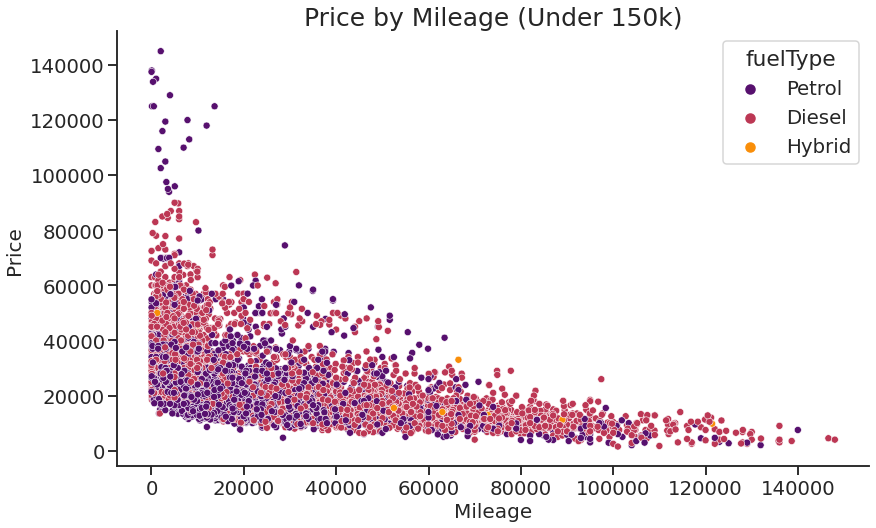

In [45]:
plt.figure(figsize=(12,8))
plt.title("Price by Mileage (Under 150k)",fontsize = 25)
sns.scatterplot(data = audi.query('mileage < 150000'), y = 'price', 
                x = 'mileage', hue = 'fuelType',
               palette = 'inferno', s = 50)
plt.ylabel("Price ", fontsize = 20)
plt.xlabel("Mileage", fontsize = 20)
sns.despine()
plt.show()

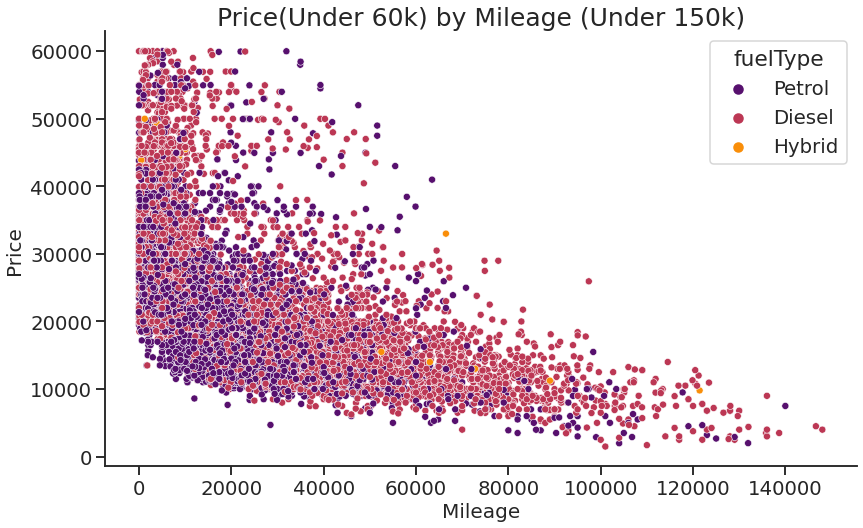

In [46]:
plt.figure(figsize=(12,8))
plt.title("Price(Under 60k) by Mileage (Under 150k)",fontsize = 25)
sns.scatterplot(data = audi.query('mileage < 150001 and price < 60001'), y = 'price', x = 'mileage', hue = 'fuelType',
               palette = 'inferno', s = 50)
plt.ylabel("Price ", fontsize = 20)
plt.xlabel("Mileage", fontsize = 20)
sns.despine()
plt.show()

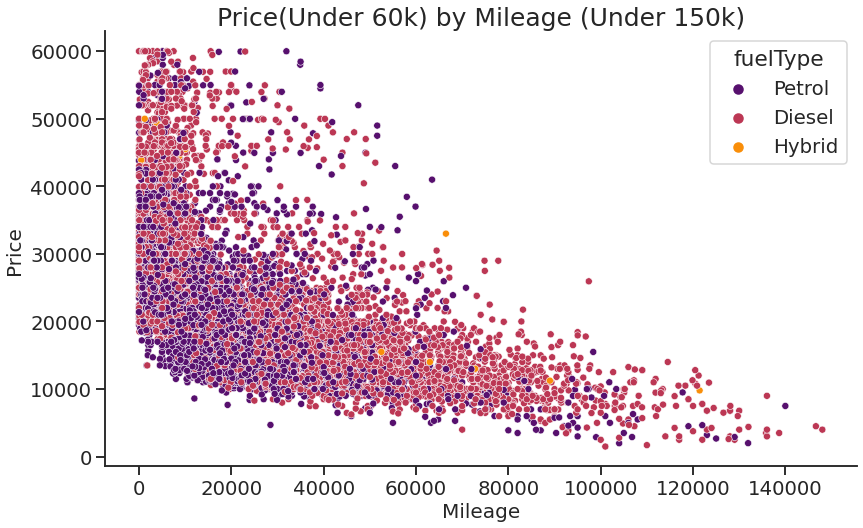

In [47]:
plt.figure(figsize=(12,8))
plt.title("Price(Under 60k) by Mileage (Under 150k)",fontsize = 25)
sns.scatterplot(data = audi.query('mileage < 150001 and price < 60001'), y = 'price', x = 'mileage', hue = 'fuelType',
               palette = 'inferno', s = 50)
plt.ylabel("Price ", fontsize = 20)
plt.xlabel("Mileage", fontsize = 20)
sns.despine()
plt.show()

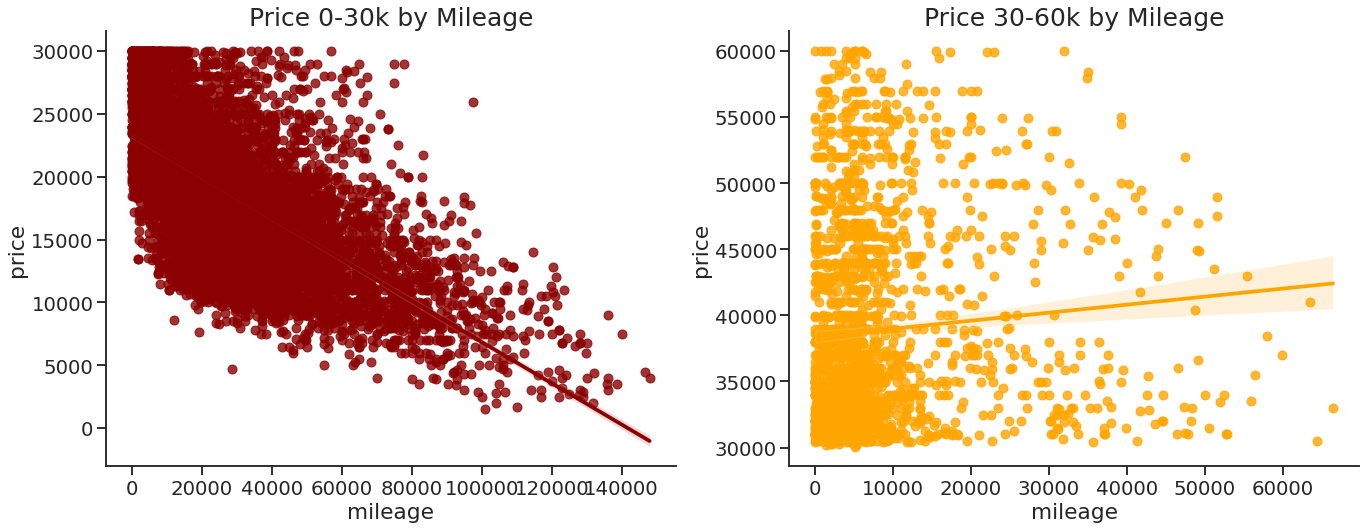

In [48]:
f= plt.figure(figsize=(20,8))

ax=f.add_subplot(121)
sns.regplot(data = audi.query('price < 30000 and price > 0 and mileage < 150000'), 
            x = 'mileage', y='price', color = 'darkred')
ax.set_title('Price 0-30k by Mileage', fontsize = 25, )

ax=f.add_subplot(122)
sns.regplot(data = audi.query('price > 30000 and price <60000'), x = 'mileage',
            y='price',color = 'orange')
ax.set_title('Price 30-60k by Mileage', fontsize = 25, )
sns.despine()
plt.show()

HMMMMMMMMMMM kind of interesting. The negative correlation seems to be more pronounced for cars 0-30000

In [50]:
# plt.figure(figsize=(8,5))
# plt.title("Price ($60k and Under) by Mileage (150,000 miles and Under) for A1",fontsize = 25)
# sns.scatterplot(data = audi.query('mileage < 150001 and price < 60001 and model == "A1"'), y = 'price', x = 'mileage', hue = 'fuelType',
#                palette = 'mako', s = 50)
# plt.ylabel("Price ", fontsize = 11)
# plt.xlabel("Mileage", fontsize = 11)
# sns.despine()
# plt.show()

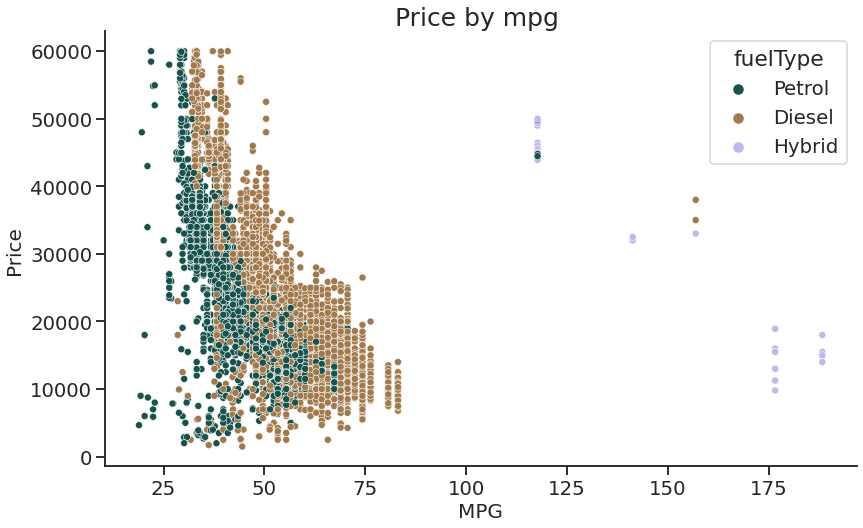

In [51]:
plt.figure(figsize=(12,8))
plt.title("Price by mpg ",fontsize = 25)
sns.scatterplot(data = audi.query('price < 60000'), y = 'price', x = 'mpg', hue = 'fuelType',
               palette = 'cubehelix', s = 50)
plt.ylabel("Price ", fontsize = 20)
plt.xlabel("MPG", fontsize = 20)
sns.despine()
plt.show()


In [53]:
# Filter out hybrid MPGs

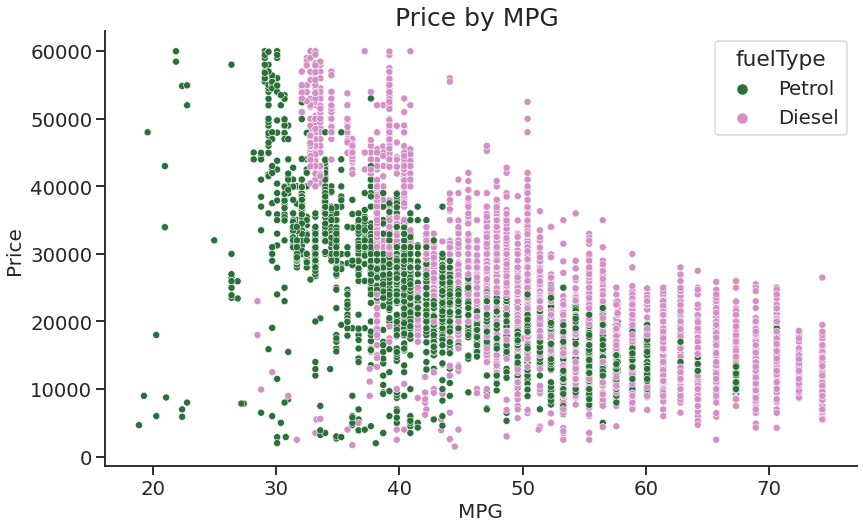

In [54]:
plt.figure(figsize=(12,8))
plt.title("Price by MPG ",fontsize = 25)
sns.scatterplot(data = audi.query('price < 60000 and mpg < 75'), y = 'price', x = 'mpg', hue = 'fuelType',
               palette = 'cubehelix', s = 50)
plt.ylabel("Price ", fontsize = 20)
plt.xlabel("MPG", fontsize = 20)
sns.despine()
plt.show()

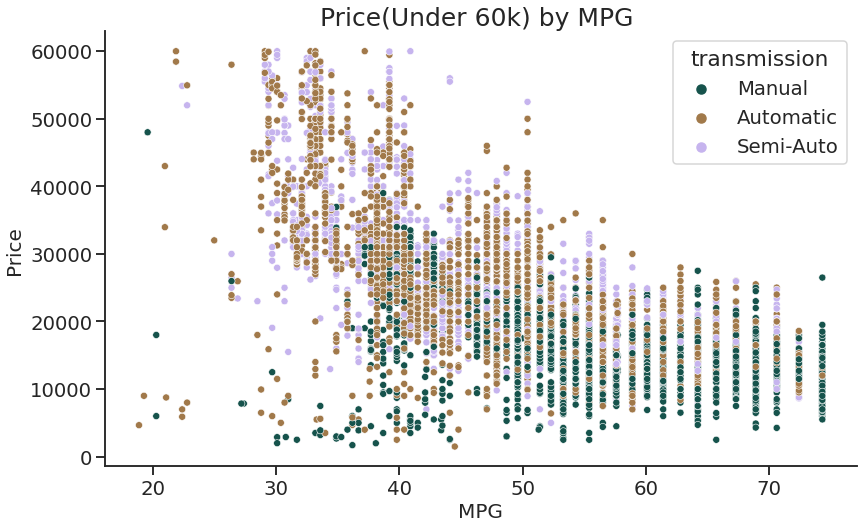

In [55]:
plt.figure(figsize=(12,8))
plt.title("Price(Under 60k) by MPG ",fontsize = 25)
sns.scatterplot(data = audi.query('price < 60000 and mpg < 75'), y = 'price', x = 'mpg', hue = 'transmission',
               palette = 'cubehelix', s = 50)
plt.ylabel("Price ", fontsize = 20)
plt.xlabel("MPG", fontsize = 20)
sns.despine()
plt.show()

In [58]:
# Two scatterplots, one with price 10-30k one with price 30k-60k. Why not 

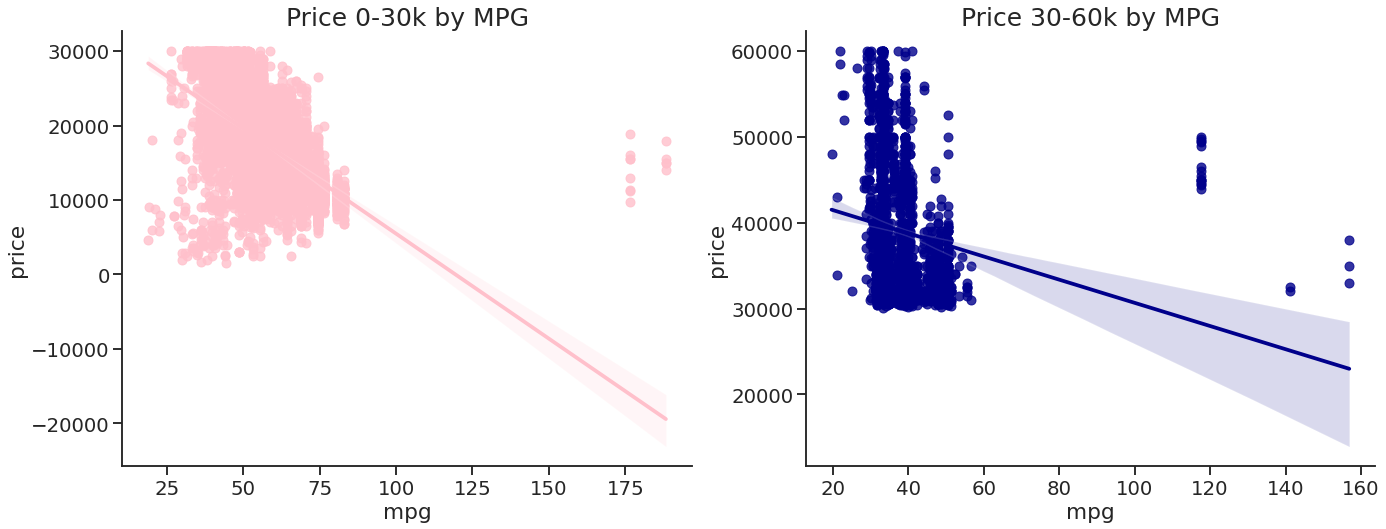

In [59]:
f= plt.figure(figsize=(20,8))

ax=f.add_subplot(121)
sns.regplot(data = audi.query('price < 30000'), x = 'mpg', y='price', color = 'pinK')
ax.set_title('Price 0-30k by MPG', fontsize = 25, )

ax=f.add_subplot(122)
sns.regplot(data = audi.query('price > 30000 and price <60000'), x = 'mpg',y='price',color = 'darkblue')
ax.set_title('Price 30-60k by MPG', fontsize = 25, )
sns.despine()
plt.show()

In [61]:
# OUTLIERS are killing this regression. 
# Those darn hybrids (its not that good even without them)

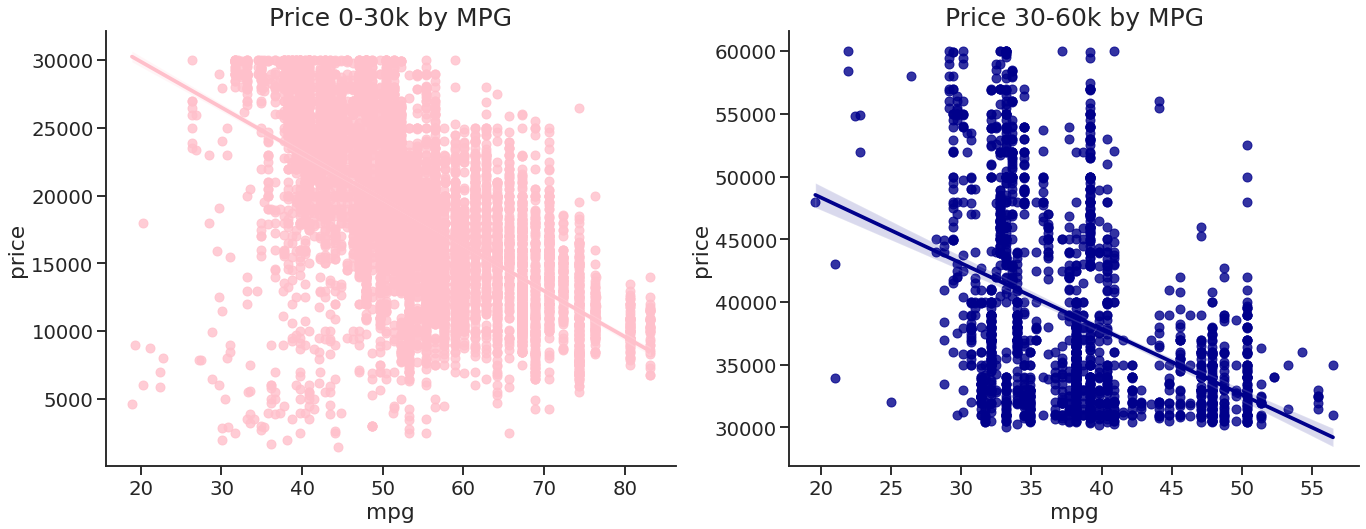

In [62]:
f= plt.figure(figsize=(20,8))

ax=f.add_subplot(121)
sns.regplot(data = audi.query('price < 30000 and mpg < 100'), x = 'mpg', y='price', color = 'pink')
ax.set_title('Price 0-30k by MPG', fontsize = 25, )

ax=f.add_subplot(122)
sns.regplot(data = audi.query('price > 30000 and price <60000 and mpg < 100'), x = 'mpg',y='price',color = 'darkblue')
ax.set_title('Price 30-60k by MPG', fontsize = 25, )
sns.despine()
plt.show()

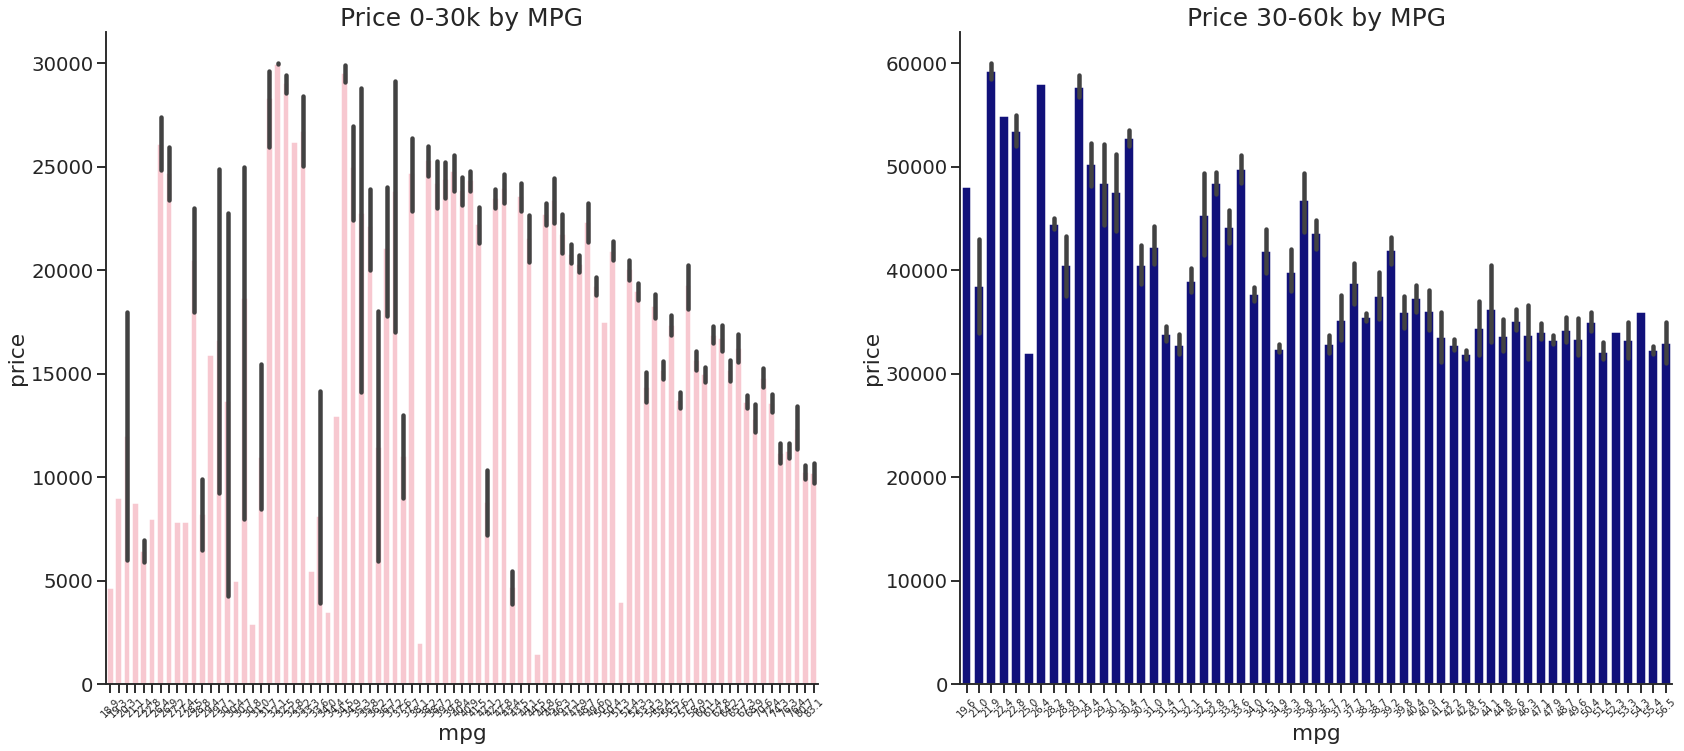

In [63]:
f= plt.figure(figsize=(25,12))

ax=f.add_subplot(121)
sns.barplot(data = audi.query('price < 30000 and mpg < 100'), x = 'mpg', y='price', color = 'pink')
ax.set_title('Price 0-30k by MPG', fontsize = 25, )
plt.xticks(rotation=45,size=10)

ax=f.add_subplot(122)
sns.barplot(data = audi.query('price > 30000 and price <60000 and mpg < 100'), x = 'mpg',y='price',color = 'darkblue')
ax.set_title('Price 30-60k by MPG', fontsize = 25, )
sns.despine()
plt.xticks(rotation=45,size = 10)
plt.show()


The most important factor in determing a car price when looking at a certain brand (Audi in this case) is obviously the MODEL of car. There's so much noise in this data because we're looking at many different models

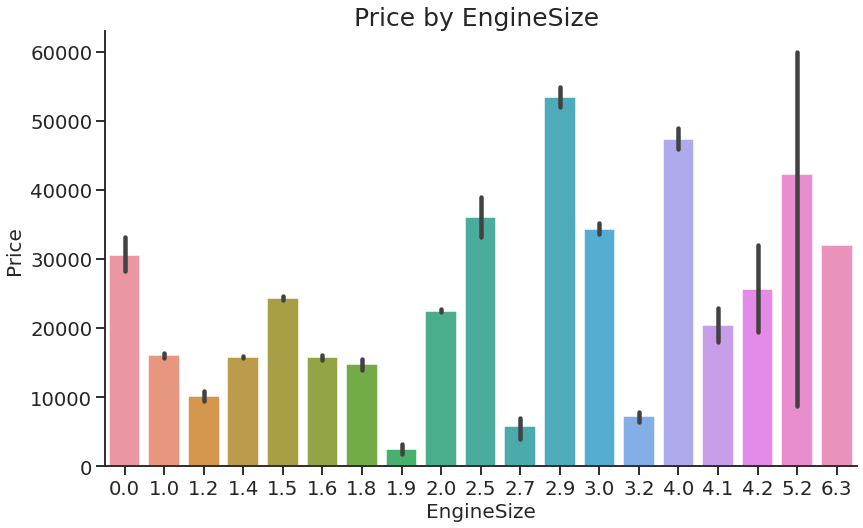

In [64]:
plt.figure(figsize=(12,8))
plt.title("Price by EngineSize ",fontsize = 25)
sns.barplot(data = audi.query('price < 60000'), y = 'price', x = 'engineSize',)
plt.ylabel("Price ", fontsize = 20)
plt.xlabel("EngineSize", fontsize = 20)
sns.despine()
plt.show()
#i like using barplots occasionally for data, esp when we're guessing price which always starts at 0


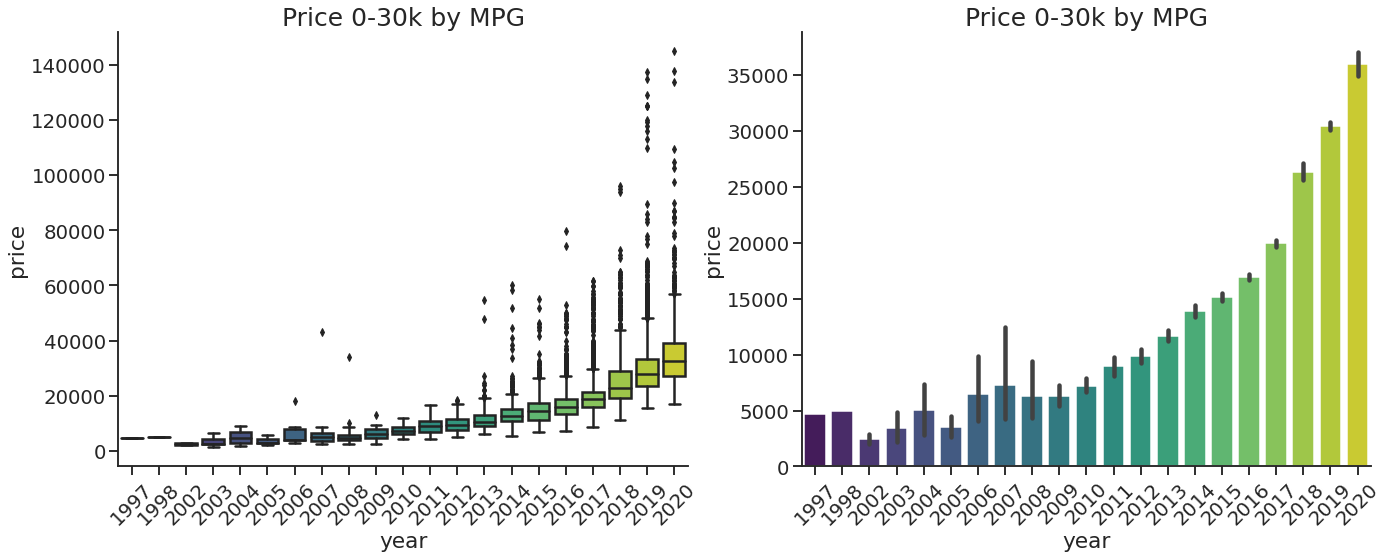

In [65]:
f= plt.figure(figsize=(20,8))

ax=f.add_subplot(121)
sns.boxplot(data = audi, x = 'year', y='price', palette = 'viridis')
ax.set_title('Price 0-30k by MPG', fontsize = 25, )
plt.xticks(rotation=45)

ax=f.add_subplot(122)
sns.barplot(data = audi, x = 'year',y='price',palette = 'viridis')
ax.set_title('Price 0-30k by MPG', fontsize = 25, )
sns.despine()
plt.xticks(rotation=45)

plt.show()

In [66]:
# outliers only displayed in boxplots (could probably change barplot params, 
#                                      but dont want to)

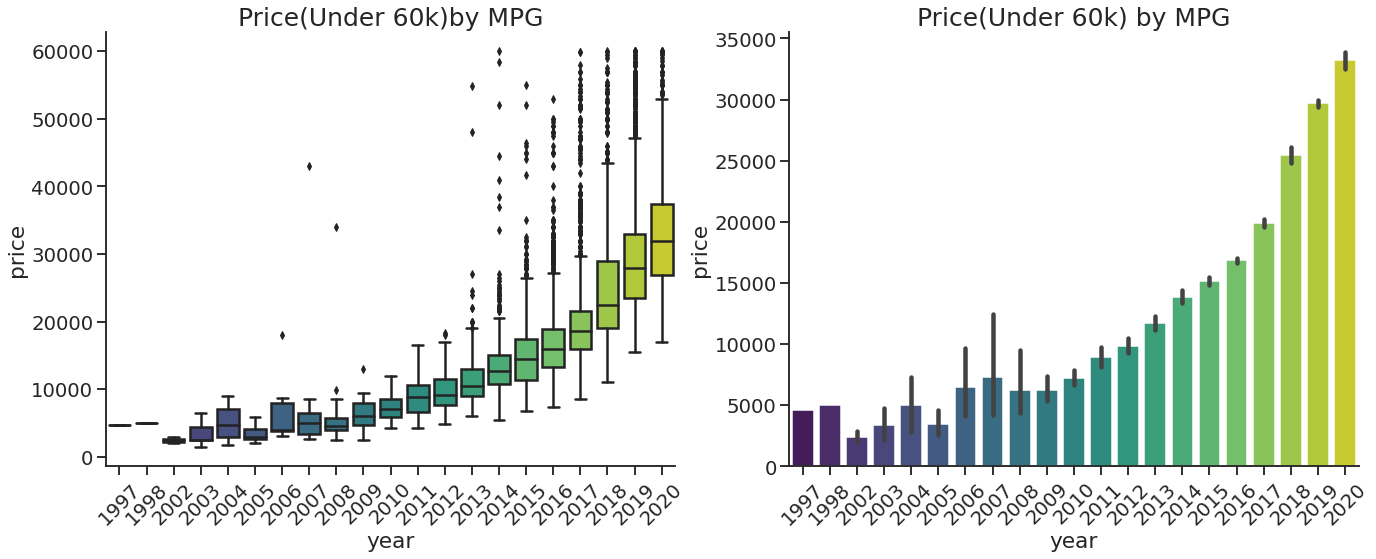

In [67]:
f= plt.figure(figsize=(20,8))

ax=f.add_subplot(121)
sns.boxplot(data = audi.query('price < 60000'), x = 'year', y='price', palette = 'viridis')
plt.xticks(rotation=45)
ax.set_title('Price(Under 60k)by MPG', fontsize = 25, )

ax=f.add_subplot(122)
sns.barplot(data = audi.query('price < 60000'), x = 'year',y='price',palette = 'viridis')
ax.set_title('Price(Under 60k) by MPG', fontsize = 25, )
plt.xticks(rotation=45)
sns.despine()
plt.show()

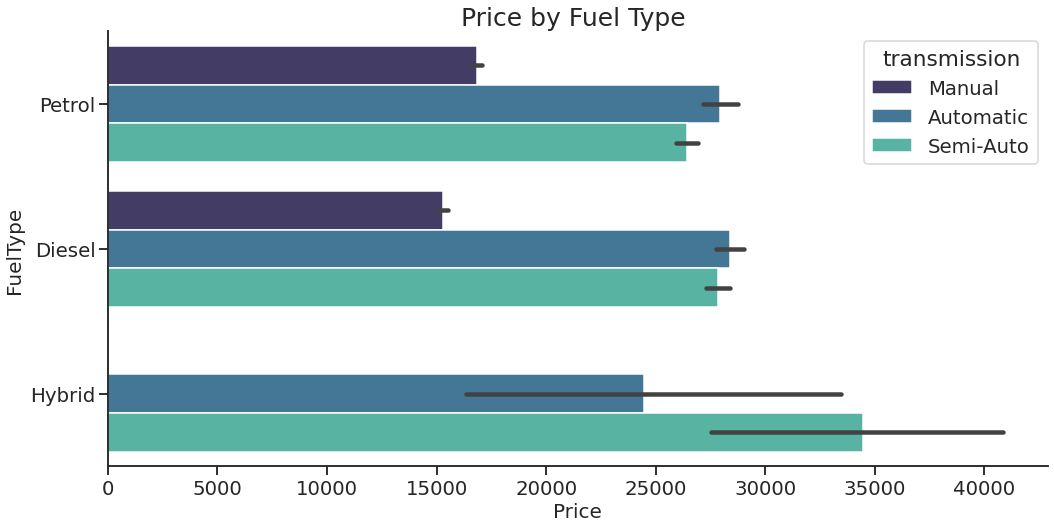

In [68]:
plt.figure(figsize=(15,8))
plt.title("Price by Fuel Type ",fontsize = 25)
sns.barplot(data = audi, y = 'fuelType', x = 'price',
               palette = 'mako', orient = 'h', hue = 'transmission')
plt.ylabel("FuelType ", fontsize = 20)
plt.xlabel("Price", fontsize = 20)
sns.despine()
plt.show()

In [69]:
# The story of this dataset is that many features have a few massive outliers.
# I made the model first and did EDA second, will try to tune model to better deal with outliers, 
# at least for linear regression.

In [71]:
# Correlations

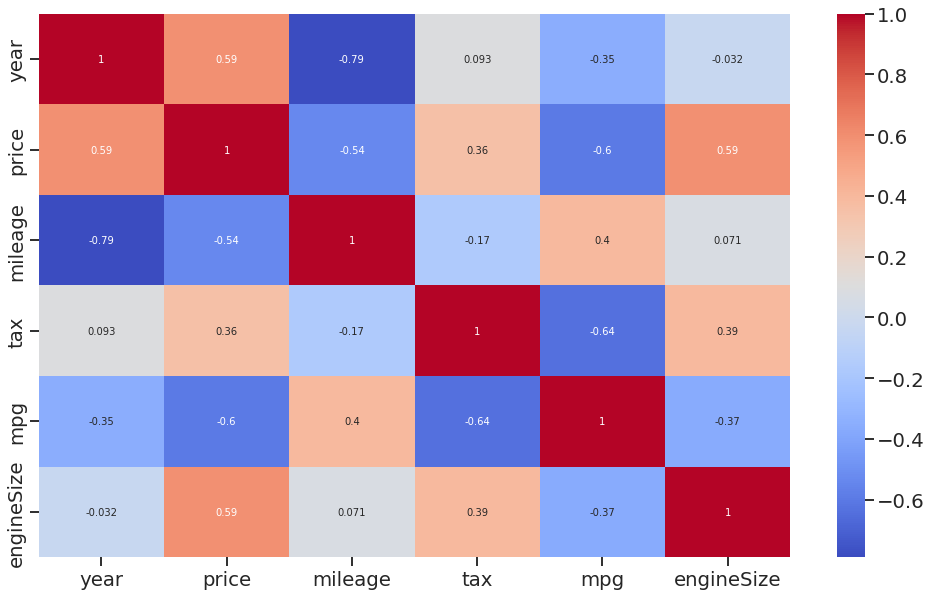

In [72]:
plt.figure(figsize = (15, 10))
sns.heatmap(audi.corr(), annot = True, cmap="coolwarm")
plt.show()

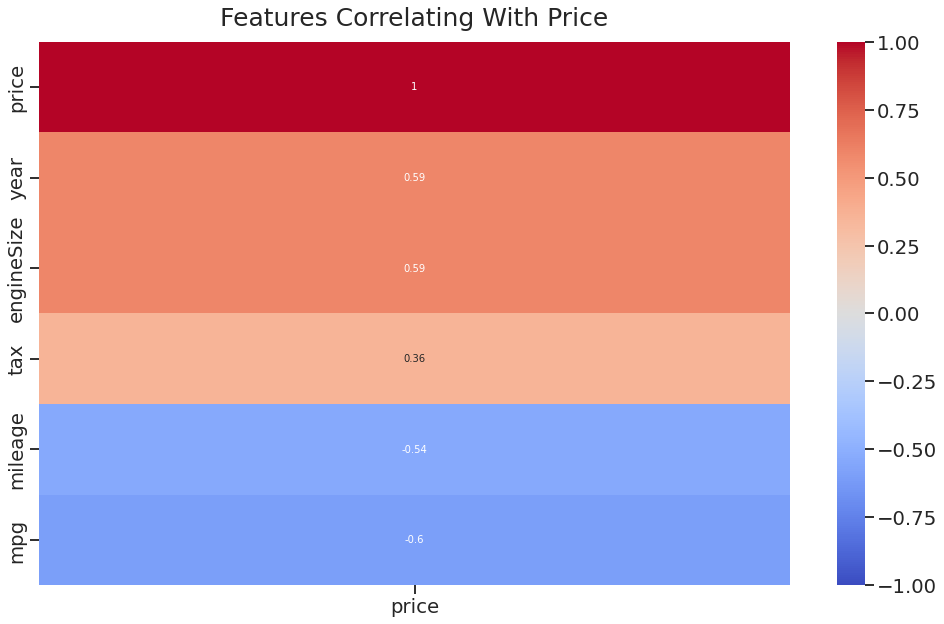

In [73]:
plt.figure(figsize = (15, 10))
heatmap = sns.heatmap(audi.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Features Correlating With Price', fontdict={'fontsize':25}, pad=16)
plt.show()

In [74]:
# Scale, Encode Data

In [75]:
# def preprocessor(df):
df = audi.copy()
#GET DUMMIES
df = pd.get_dummies(df)

#SCALE DATA
scaler = StandardScaler()
scaler.fit(df)

#     return df
# preprocessor(ford)

StandardScaler()

In [76]:
# Linear Regression, Splitting Data

0.8911
Coefficients: 
 [ 1.81870856e+03 -7.82997915e-02 -2.87907213e+01 -2.87880618e+02
  4.46862746e+03 -1.18902139e+04  7.26716217e+03 -1.05217378e+04
 -1.01710914e+04 -8.87352656e+03 -8.23301111e+03 -7.40254776e+03
 -3.89773175e+03 -1.03956287e+04 -8.97717897e+03 -4.87735742e+03
  3.31448780e+03  1.30049097e+04  4.92238975e+04 -2.08145071e+03
  1.10851102e+04  8.33597763e+03  1.39563898e+04  6.99976700e+03
 -7.95019339e+03 -3.03023524e+03 -9.87005164e+03 -2.10875556e+03
 -1.57203023e+03  7.02534857e+03 -8.36030826e+03  4.55395401e+02
 -1.05658173e+03  6.01186327e+02 -1.07206330e+04  2.22629304e+04
 -1.15422975e+04]
Mean squared error: 14432476.41
Coefficient of determination: 0.8911


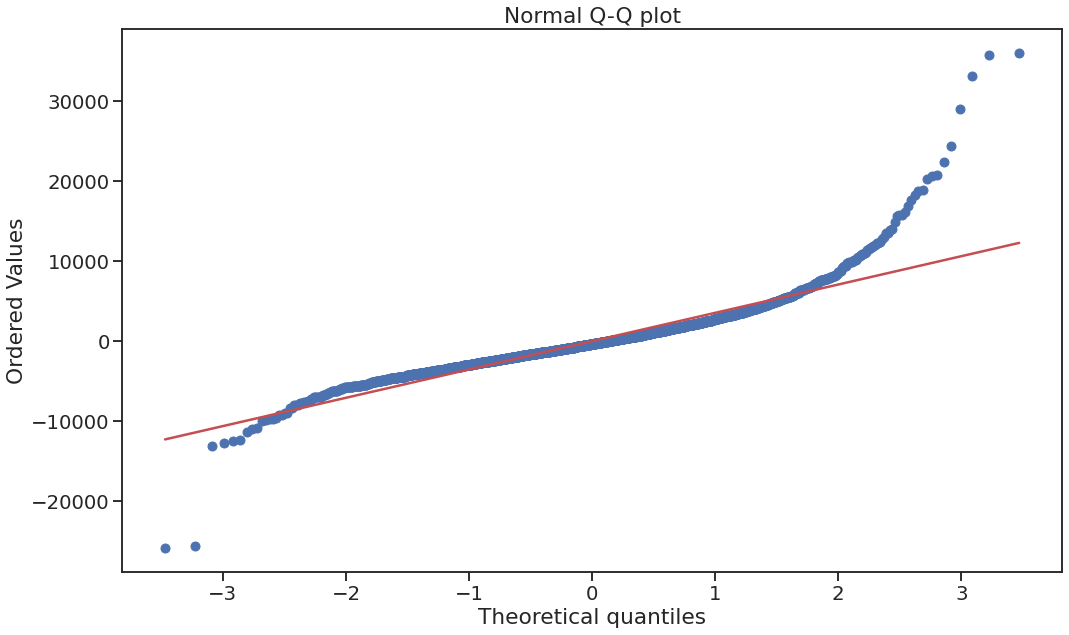

In [77]:
# def build_model(df):
X = df.drop('price', axis = 1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=1)

lr = LinearRegression().fit(X_train,y_train)
y_train_pred = lr.predict(X_train)

y_pred = lr.predict(X_test)

print(round(lr.score(X_test,y_test),4))
# The coefficients
print("Coefficients: \n", lr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.4f" % r2_score(y_test, y_pred))

#QQ plot

residuals = y_test - y_pred
plt.figure(figsize=(15,10))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()


# return lr

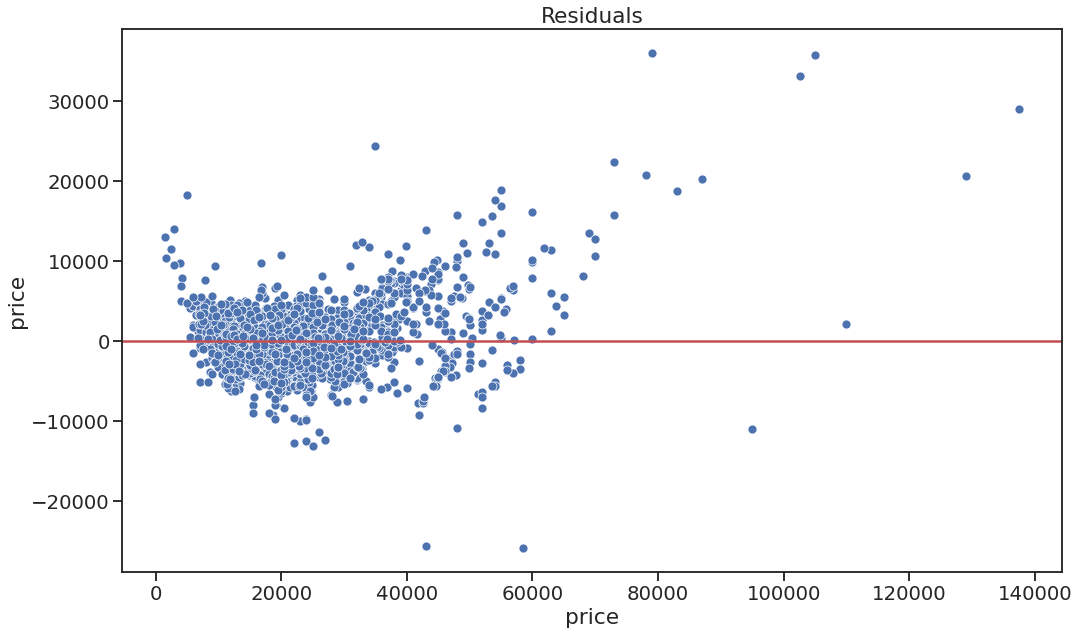

In [78]:
residuals = y_test - y_pred
plt.figure(figsize = (15,10))
plt.title("Residuals")
sns.scatterplot(x=y_test,y=residuals)
plt.axhline(y=0, color='r',)
plt.show()

In [79]:
# These residuals are not heteroskedastic! Unsurprising as the data is not even close to 
# being normally distributed. This is a problem

In [80]:
# Feature Importance

In [81]:
importance = lr.coef_
for i, v in enumerate(importance):
    print( 'Feature :%0d, Score %.5f' % (i,v))


Feature :0, Score 1818.70856
Feature :1, Score -0.07830
Feature :2, Score -28.79072
Feature :3, Score -287.88062
Feature :4, Score 4468.62746
Feature :5, Score -11890.21393
Feature :6, Score 7267.16217
Feature :7, Score -10521.73776
Feature :8, Score -10171.09145
Feature :9, Score -8873.52656
Feature :10, Score -8233.01111
Feature :11, Score -7402.54776
Feature :12, Score -3897.73175
Feature :13, Score -10395.62873
Feature :14, Score -8977.17897
Feature :15, Score -4877.35742
Feature :16, Score 3314.48780
Feature :17, Score 13004.90974
Feature :18, Score 49223.89751
Feature :19, Score -2081.45071
Feature :20, Score 11085.11021
Feature :21, Score 8335.97763
Feature :22, Score 13956.38982
Feature :23, Score 6999.76700
Feature :24, Score -7950.19339
Feature :25, Score -3030.23524
Feature :26, Score -9870.05164
Feature :27, Score -2108.75556
Feature :28, Score -1572.03023
Feature :29, Score 7025.34857
Feature :30, Score -8360.30826
Feature :31, Score 455.39540
Feature :32, Score -1056.5817

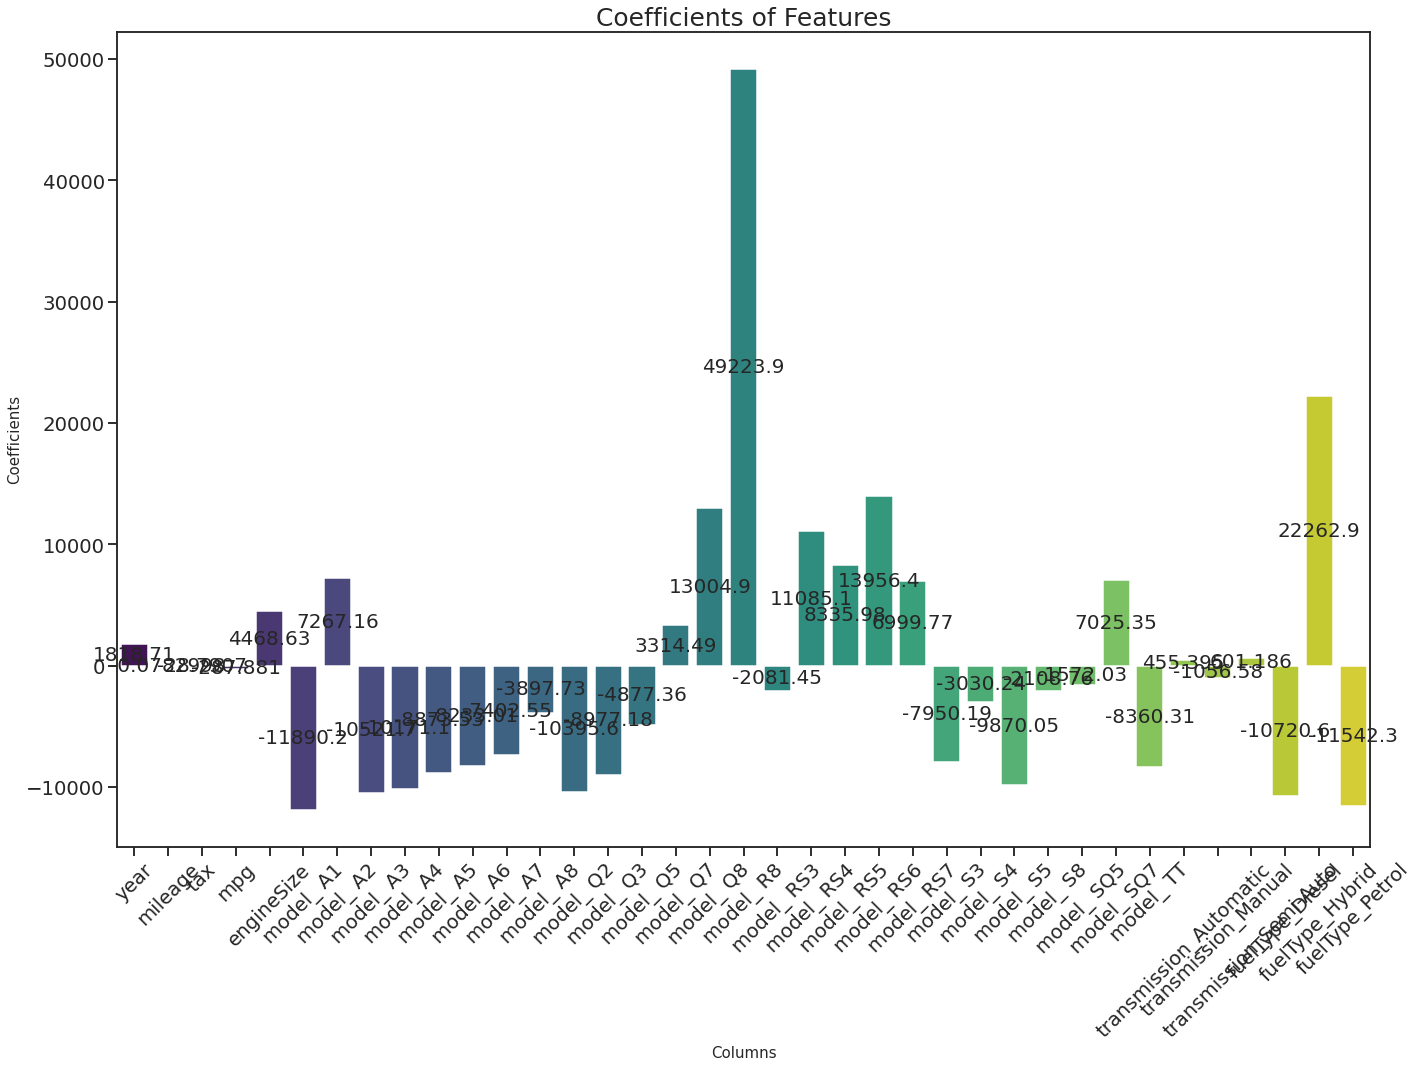

In [82]:
column_names = X.columns
column_coef =pd.DataFrame({"columns" :column_names,
             "coef_":lr.coef_})

plt.figure(figsize = (20,15))
ax =sns.barplot(data =column_coef, x = "columns", y = "coef_", palette = 'viridis')

plt.bar_label(ax.containers[0],size=20,label_type="center")
plt.xlabel("Columns",size = 15)
plt.ylabel("Coefficients",size = 15)
plt.title("Coefficients of Features",fontsize = 25)
plt.xticks(rotation=45)
plt.show()

In [83]:
# Why is Model_ Q8 so important?

In [84]:
# X = sm.add_constant(X)
# lin = sm.OLS(y_train,X_train).fit()
# lin.summary()
# #plot an influence plot of the features in the linear regression model above
# fig, ax = plt.subplots(figsize=(12,8))
# fig = sm.graphics.influence_plot(lin, ax=ax, criterion="cooks")

# #plot a residual plot of the linear regression model above
# fig, ax = plt.subplots(figsize=(12,8))
# fig = sm.graphics.plot_regress_exog(lin, "RM", ax=ax)

In [85]:
# #lazyregressor to evaluate all model performance
# clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
# models,predictions = clf.fit(X_train, X_test, y_train, y_test)
# print(models)

In [86]:
# Ensemble Model

In [87]:
models = {
    "catboost": CatBoostRegressor(verbose = 0),
    "bayesianridge": BayesianRidge(),
    "lightgbm": LGBMRegressor(),
    "ridge": Ridge(),
    "orthogonalmatchingpursuit": OrthogonalMatchingPursuit(),
    'linreg': LinearRegression(),
    'xgboost': XGBRegressor(),
    'randomforest': RandomForestRegressor(),
    'decisiontree': DecisionTreeRegressor(),
    'supportvector' : SVR()  
}

In [88]:
#simple version of what we're doing below using .items() function and dictionary of models
my_dict = {'a':1,'b':2,'c':3}
for key, value in my_dict.items():
    print(key, value)

a 1
b 2
c 3


In [89]:
#Train the dictionary of models above
for model_name, model in models.items():
    model.fit(X_train, y_train) #operations we want to perform on our ditionary items go here 
    y_pred = model.predict(X_test)
    print(model_name, 'R^2 Value', (model.score(X_test,y_test)))


catboost R^2 Value 0.9635271480544405
bayesianridge R^2 Value 0.8910541237273261
lightgbm R^2 Value 0.9569258376910442
ridge R^2 Value 0.8909188021839192
orthogonalmatchingpursuit R^2 Value 0.7617010650345121
linreg R^2 Value 0.8910508455473227
[11:38:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgboost R^2 Value 0.936478628994433
randomforest R^2 Value 0.9557756994088482
decisiontree R^2 Value 0.9220470875233058
supportvector R^2 Value 0.03440812643767943


In [90]:
# #Create a new model using the best model from above
# catboost = CatBoostRegressor(verbose = 0)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# print("CatBoostRegressor:", np.sqrt(mean_squared_error(y_test, y_pred)))
# print("CatBoostRegressor:",'R^2 Value', (model.score(X_test,y_test)))

In [91]:
# Ensembling Models
# REDUCE VARIANCE OF ANY ONE MODEL. MANY OF OUR MODELS HAVE HIGH R2 SCORE (LOW BIAS) ALREADY

In [92]:
ensemble = (
    0.2 * (models['catboost'].predict(X_test)) +
    0.1 * (models['bayesianridge'].predict(X_test)) +
    0.1 * (models['lightgbm'].predict(X_test)) +
    0.1 * (models['ridge'].predict(X_test)) +
    0.1 * (models['orthogonalmatchingpursuit'].predict(X_test)) + 
    0.1 * (models['linreg'].predict(X_test)) +
    0.1 * (models['xgboost'].predict(X_test)) +
    0.1 * (models['randomforest'].predict(X_test)) +
    0.1 * (models['decisiontree'].predict(X_test))    
)

In [93]:
pd.DataFrame(ensemble)
pd.Series(y_test)
ensemble_predictions=pd.DataFrame(ensemble).join(y_test)
ensemble_predictions.dropna(inplace=True)
df2 = ensemble_predictions.copy()
columns = ['Predicted','Actual']
dict = {'0':'Predicted',
       'price':'Actual'}

In [95]:
df2.rename(columns = dict,
          inplace = True)

In [96]:
df2.columns

Index([0, 'Actual'], dtype='object')

<AxesSubplot:>

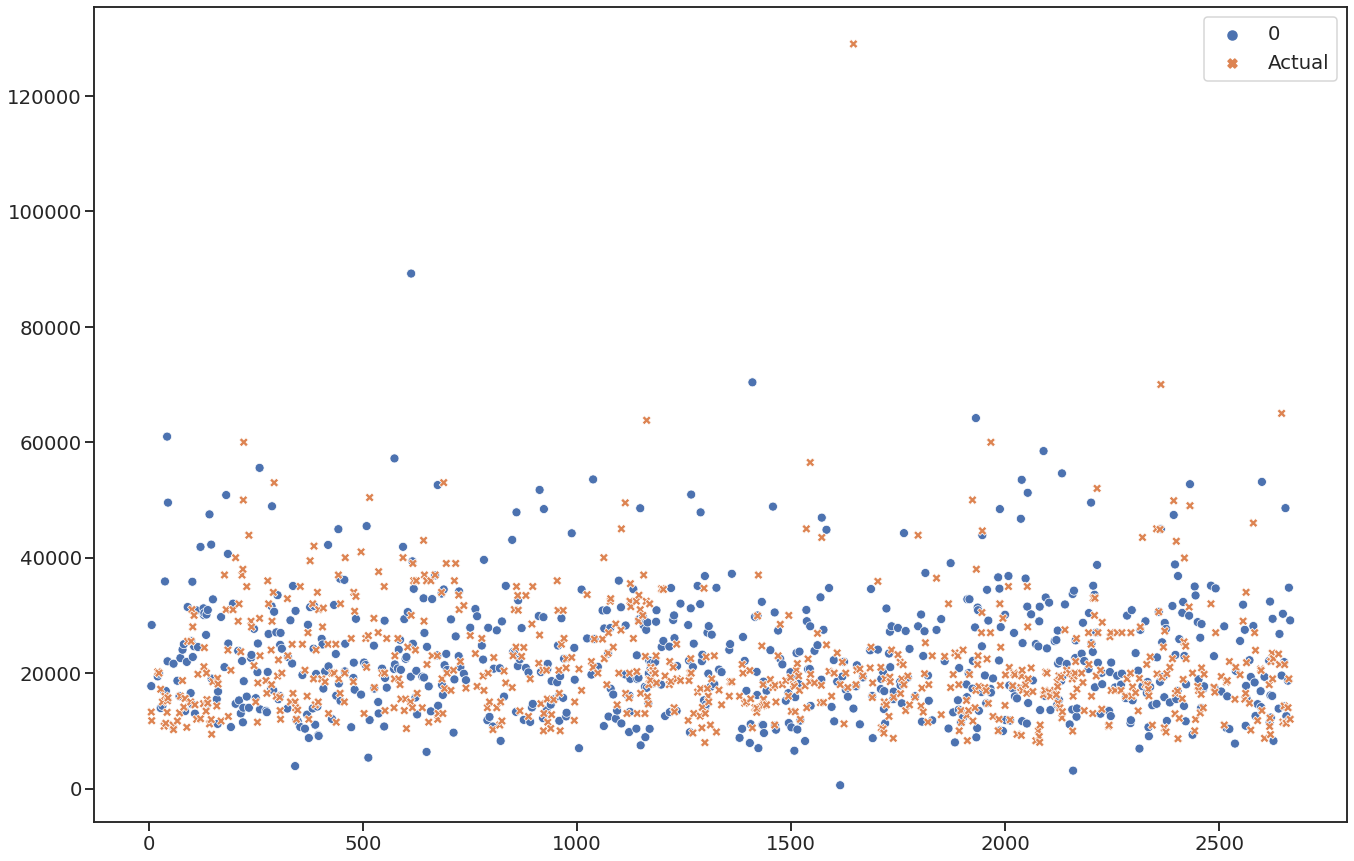

In [97]:
plt.figure(figsize = (20,15))
sns.scatterplot(data = df2)

In [98]:
# # create a figure
# fig = plt.figure(figsize=(10,10))

# # create a scatter plot of the residuals
# plt.scatter(x=df2['0'], y=df2['Actual'], s=100, alpha=0.5)

# # add a line of best fit
# plt.plot(df2['price'], df2['price'], color='r')

# # add a title
# plt.title('Ensemble Predictions vs Actual')

# # add axis labels
# plt.xlabel('Actual')
# plt.ylabel('Predicted')

# # add a grid
# plt.grid(True)


In [100]:
# Hyperparemeter Tuning Using GridSearchCV

In [101]:
models = {
    "catboost": CatBoostRegressor(verbose = 0),
    "br": BayesianRidge(),
    "lightgbm": LGBMRegressor(),
    "ridge": Ridge(),
    "omp": OrthogonalMatchingPursuit(),
    'linreg': LinearRegression(),}
params = {
    "catboost": {
        "iterations": [100, 200, 300],
        "learning_rate": [0.01, 0.05, 0.1],
        "depth": [3, 4, 5, 6, 7, 8],
        "l2_leaf_reg": [1, 3, 5, 7, 9],
    },
    "br": {
        "n_iter": [300, 500, 700],
        "tol": [1e-3, 1e-4, 1e-5],
    },
    "lightgbm": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.05, 0.1],
        "num_leaves": [3, 5, 7, 9],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "subsample": [0.6, 0.8, 1.0],
        "reg_alpha": [0.1, 0.5, 1.0],
        "reg_lambda": [0.1, 0.5, 1.0],
    },
    "ridge": {
        "alpha": [0.1, 0.5, 1.0, 2.0, 5.0, 7.0, 10.0, 20.0, 50.0, 100.0],
    },
    "omp": {
        "n_nonzero_coefs": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    },
    "linreg": {
        "fit_intercept": [True, False],
    },
}

#create a dictionary called scores to store the scores of each model
scores = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(model, params[model_name], cv = 5, n_jobs = -1, verbose = 0)
    grid_search.fit(X_train, y_train)
    scores[model_name] = grid_search.best_score_
    print(f"{model_name} score: {scores[model_name]}")

print(f"\nBest model: {max(scores, key = scores.get)}",)

Training catboost...
catboost score: 0.9643746091261273
Training br...
br score: 0.8892328611557371
Training lightgbm...
lightgbm score: 0.9558367003448618
Training ridge...
ridge score: 0.8892334710639727
Training omp...


/home/hrushikesh/isolation/base/lib/python3.10/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), OrthogonalMatchingPursuit())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/home/hrushikesh/isolation/base/lib/python3.10/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing st

omp score: 0.8888701052200402
Training linreg...
linreg score: 0.8892230812780483

Best model: catboost


In [102]:
scores

{'catboost': 0.9643746091261273,
 'br': 0.8892328611557371,
 'lightgbm': 0.9558367003448618,
 'ridge': 0.8892334710639727,
 'omp': 0.8888701052200402,
 'linreg': 0.8892230812780483}

In [105]:
type(models)

dict